In [1]:
from mlputils import Linear
from mlputils import BatchNorm1D
from mlputils import Tanh

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

g = torch.Generator().manual_seed(2147483647)

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size  # initialize with all dots
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # slide the window, by popping and appending
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [11]:
n_embed = 10 # embedding vector dimensionality
n_hidden = 100 # neurons in hidden layer

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size),
]

# layers = [
#     Linear(n_embed * block_size, n_hidden), Tanh(),
#     Linear(            n_hidden, n_hidden), Tanh(),
#     Linear(            n_hidden, n_hidden), Tanh(),
#     Linear(            n_hidden, n_hidden), Tanh(),
#     Linear(            n_hidden, n_hidden), Tanh(),
#     Linear(            n_hidden, vocab_size),
# ]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # if last layer is a batchnorm
    #layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True



47024


In [12]:
# Optimization

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # Forward pass
    emb = C[Xb] # Embed characters to vectors
    x = emb.view(emb.shape[0], -1) # concatenate all vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # Gradient
    # for layer in layers:
    #     layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    

      0/ 200000: 3.3382
  10000/ 200000: 2.1988
  20000/ 200000: 2.1184
  30000/ 200000: 2.6955
  40000/ 200000: 2.3159
  50000/ 200000: 2.0635
  60000/ 200000: 2.8935
  70000/ 200000: 2.1607
  80000/ 200000: 2.3297
  90000/ 200000: 2.2432
 100000/ 200000: 2.3267
 110000/ 200000: 1.9902
 120000/ 200000: 2.1021
 130000/ 200000: 2.0303
 140000/ 200000: 2.5511
 150000/ 200000: 2.3778
 160000/ 200000: 1.8095
 170000/ 200000: 1.8055
 180000/ 200000: 1.9764
 190000/ 200000: 1.8548


layer 2 (      Tanh): mean -0.01, std 0.69, saturated: 14.88%
layer 5 (      Tanh): mean -0.01, std 0.72, saturated: 16.06%
layer 8 (      Tanh): mean -0.01, std 0.75, saturated: 16.38%
layer 11 (      Tanh): mean -0.01, std 0.77, saturated: 16.25%
layer 14 (      Tanh): mean +0.00, std 0.79, saturated: 19.88%


Text(0.5, 1.0, 'activation distribution')

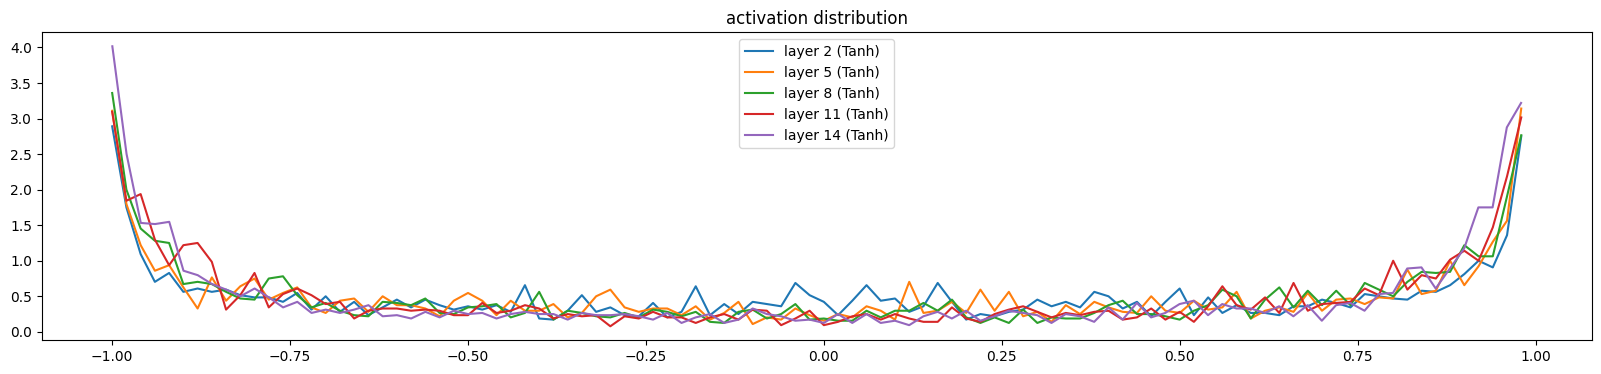

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

/var/folders/cg/5bs0ld291r3dfvx6scc_j9vm0000gn/T/ipykernel_87564/214208553.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight   (27, 10) | mean +0.000000 | std 1.677869e-02 | grad:data ratio 1.570790e-02
weight  (30, 100) | mean +0.000136 | std 9.947139e-03 | grad:data ratio 2.447888e-02
weight (100, 100) | mean -0.000132 | std 6.340083e-03 | grad:data ratio 2.573523e-02
weight (100, 100) | mean +0.000012 | std 6.440268e-03 | grad:data ratio 2.643911e-02
weight (100, 100) | mean -0.000023 | std 6.216025e-03 | grad:data ratio 2.600583e-02
weight (100, 100) | mean -0.000053 | std 5.506457e-03 | grad:data ratio 2.395098e-02
weight  (100, 27) | mean +0.000095 | std 8.593928e-03 | grad:data ratio 2.588359e-02


Text(0.5, 1.0, 'weights gradient distribution')

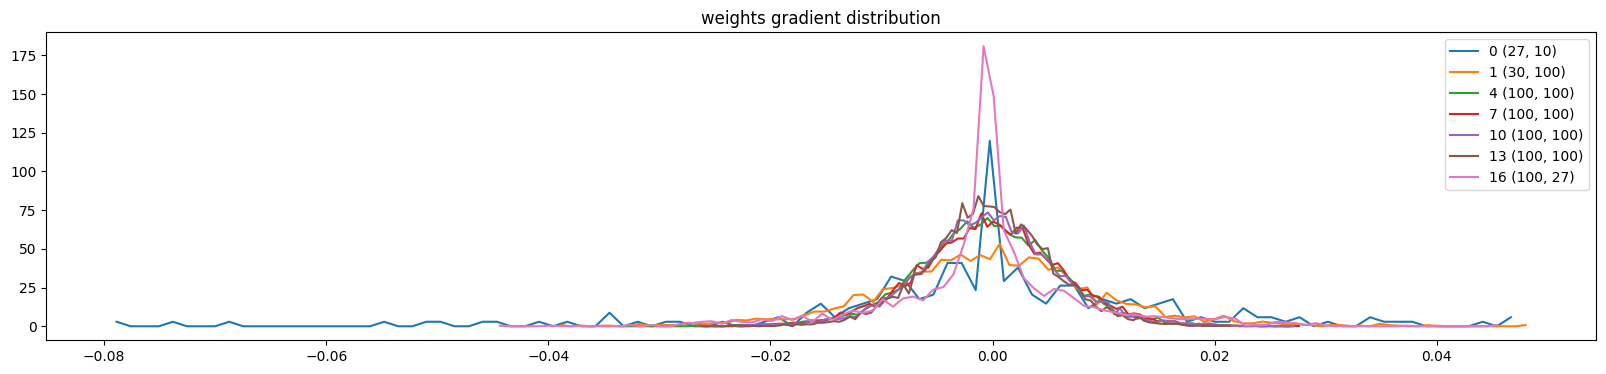

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

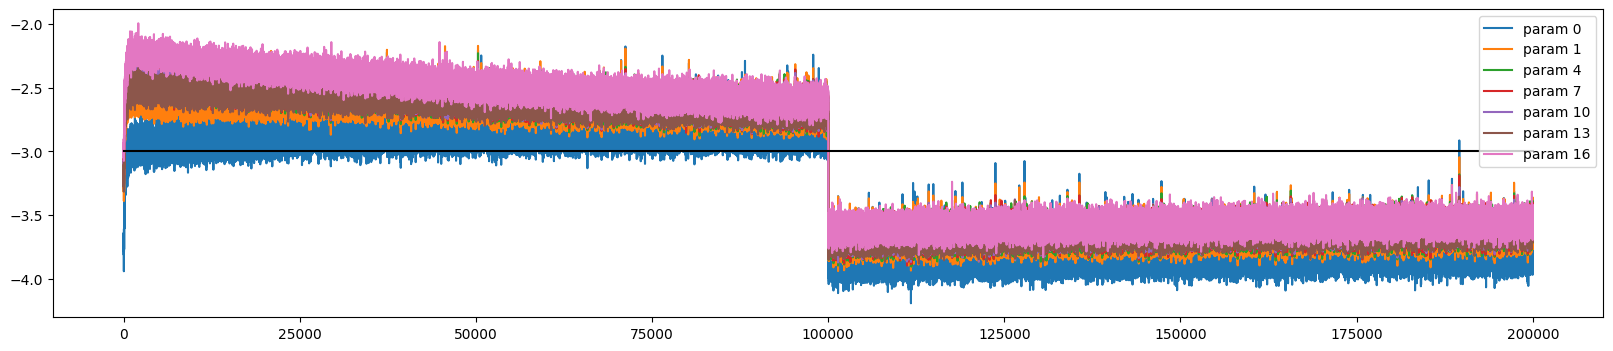

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0131795406341553
val 2.086099624633789


In [18]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amillivia.
jari.
reigh.
skansh.
eja.
hutn.
deliah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joce.
quinthonor.
raina.
bilo.
jero.
dearyn.
kai.


In [ ]:
ß